# Case 4 - Tritium Spatial Estimation
Welcome to the demonstration notebook where we'll spatially estimate tritium using the **pylenm** package!<br>
Let’s get started!

## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# pip install pylenm

In [2]:
# pip install pyproj

In [3]:
# pip install rasterio

In [4]:
# pip install elevation

In [5]:
# pip install richdem

In [6]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from math import sqrt
from sklearn.metrics import r2_score

# pylenm
import pylenm
print("pylenm version: ", pylenm.__version__)
from pylenm import PylenmDataFactory

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"

pylenm version:  0.2


In [7]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
dem_path = "./data/FArea-30m-DEM_cropped.tif"


farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

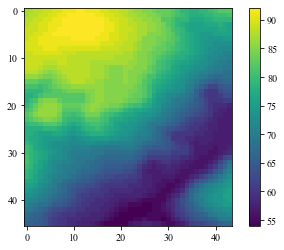

In [8]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [9]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [10]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)

## Load Well Time Series Data + Preprocess

In [11]:
# Load and process well time-series data
url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'
concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)
pylenm_df = PylenmDataFactory(concentration_data)
pylenm_df.simplify_data(inplace=True)
pylenm_df.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



In [12]:
analyte = 'TRITIUM'

Data summary for water table

In [13]:
tr_details = pylenm_df.get_analyte_details(analyte)
tr_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB 77,1990-01-01,2006-10-16,6132,65
FSB111C,1990-01-01,2006-10-17,6133,67
FSB105C,1990-01-01,2006-10-19,6135,67
FSB111D,1990-01-01,2006-10-26,6142,68
FSB107D,1990-01-01,2007-02-01,6240,68
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [14]:
n_samples = tr_details['Unique samples']
end_date = tr_details['End Date']
start_date = tr_details['Start Date']
well_names  = tr_details.index
well_enough = well_names[n_samples>20]

well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [15]:
tr_interp = pylenm_df.interpolate_wells_by_analyte(analyte, frequency='1M', rm_outliers=True, z_threshold=3)

In [16]:
tr_interp[tr_interp <= 0] = 0.001

Select the upper aquifer wells and the wells that have enough samples

44 wells


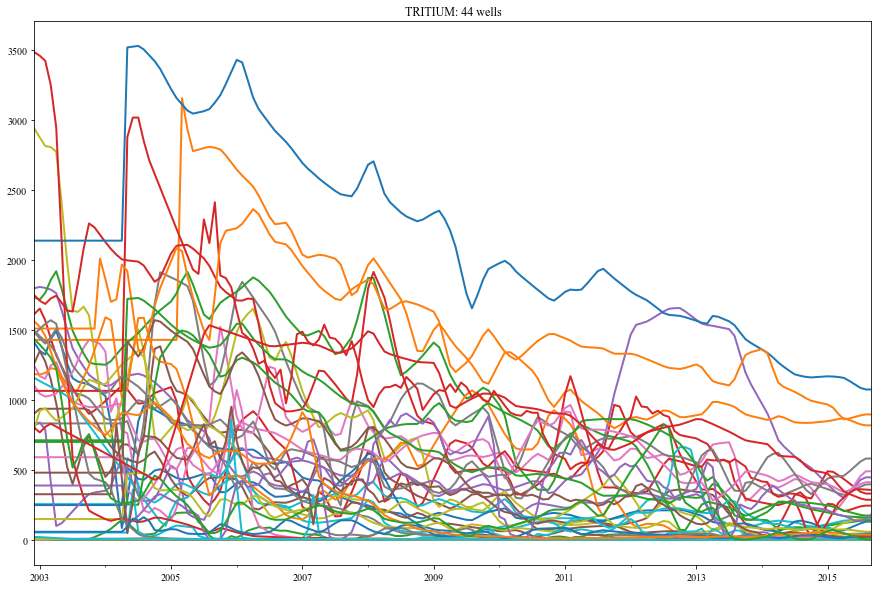

In [17]:
active = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm_df.filter_by_column(pylenm_df.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(tr_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
tr_interp = tr_interp[well_only_D]
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))
print(tr_interp.shape[1], "wells")

In [18]:
keep = list(tr_interp.describe().T[tr_interp.describe().T['min']>0].T.columns)
tr_interp = tr_interp[keep]

Let's remove the 'bad' time series wells

In [19]:
bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D', 'FSB117D']
tr_interp = tr_interp.drop(columns=bad_ones)

In [20]:
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)

38 wells


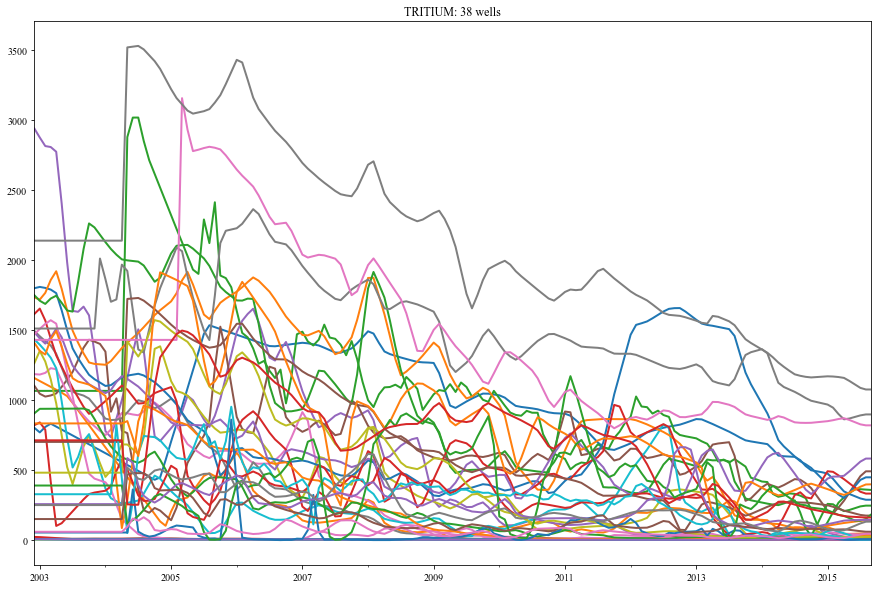

In [21]:
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))
print(tr_interp.shape[1], "wells")

## Well Location Data

In [22]:
well_info = pylenm_df.get_Construction_Data()

Match the well indecies between the time series and locations

In [23]:
shared_wells = list(set(well_info.index) & set(tr_interp.columns))
tr_interp = tr_interp[shared_wells]
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [24]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(well_info.LATITUDE,well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [25]:
well_info.LATITUDE.shape[0]

38

In [26]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

In [27]:
tr_interp.describe().T['min'].min()

0.001

In [28]:
# tr_interp = np.log2(tr_interp)
tr_interp = np.log10(tr_interp)

<AxesSubplot:>

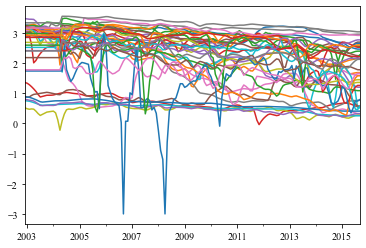

In [29]:
tr_interp.plot(legend=False)

In [30]:
# GETS APPROXIMATE tr VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
        X_approx.append([XX.iloc[index].Easting, XX.iloc[index].Northing, XX.iloc[index].Elevation])
        y_approx.append(y_map[index])
    X_approx = pd.DataFrame(X_approx, columns=['Easting', 'Northing', 'Elevation'])
    return X_approx, y_approx

In [31]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten(), slope.flatten(), accum.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

In [32]:
year = 2015
y = np.array(tr_interp.loc[tr_interp.index[pd.Series(tr_interp.index).dt.year == year]].mean())
print(y)
well_names = list(tr_interp.columns)

[2.53937381 1.73585499 2.452686   0.62319239 1.39183798 2.50963205
 1.65149981 0.72328054 1.41132869 1.34673475 2.57738302 2.09502347
 2.37203081 2.60490224 2.70073832 0.8612056  0.39576523 2.95425281
 0.22368195 0.25053464 0.40502561 0.95790845 1.12593219 0.96896256
 0.27558381 2.30711508 2.92656853 3.05159618 1.35084861 0.96369776
 0.76489731 2.55573003 2.22637235 2.23695105 2.13047544 1.8404908
 1.39984221 1.96552464]


In [34]:
def dist(p1,p2):
    return sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

def add_dist_to_basin(XX, basin_coordinate=[436642.70,3681927.09], col_name='dist_to_basin'):
    x1,y1 = basin_coordinate
    distances = []
    for i in range(XX.shape[0]):
        x2,y2 = XX.iloc[i][0], XX.iloc[i][1]
        distances.append(dist([x1,y1],[x2,y2]))
    XX[col_name] = distances
    return XX

In [35]:
b_c=[436642.70,3681927.09]
XX = add_dist_to_basin(XX, basin_coordinate=b_c)
X = add_dist_to_basin(X, basin_coordinate=b_c)

In [36]:
y_map, r_map, residuals, lr_trend = pylenm_df.interpolate_topo(X, y, XX, ft=['Elevation', 'dist_to_basin'], regression='linear', smooth=True)
y_map[y_map<0] = 0

<AxesSubplot:>

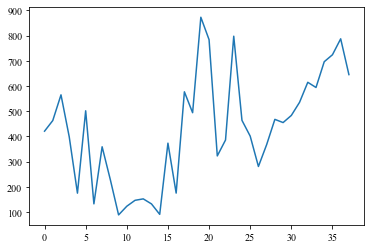

In [37]:
X.dist_to_basin.plot()

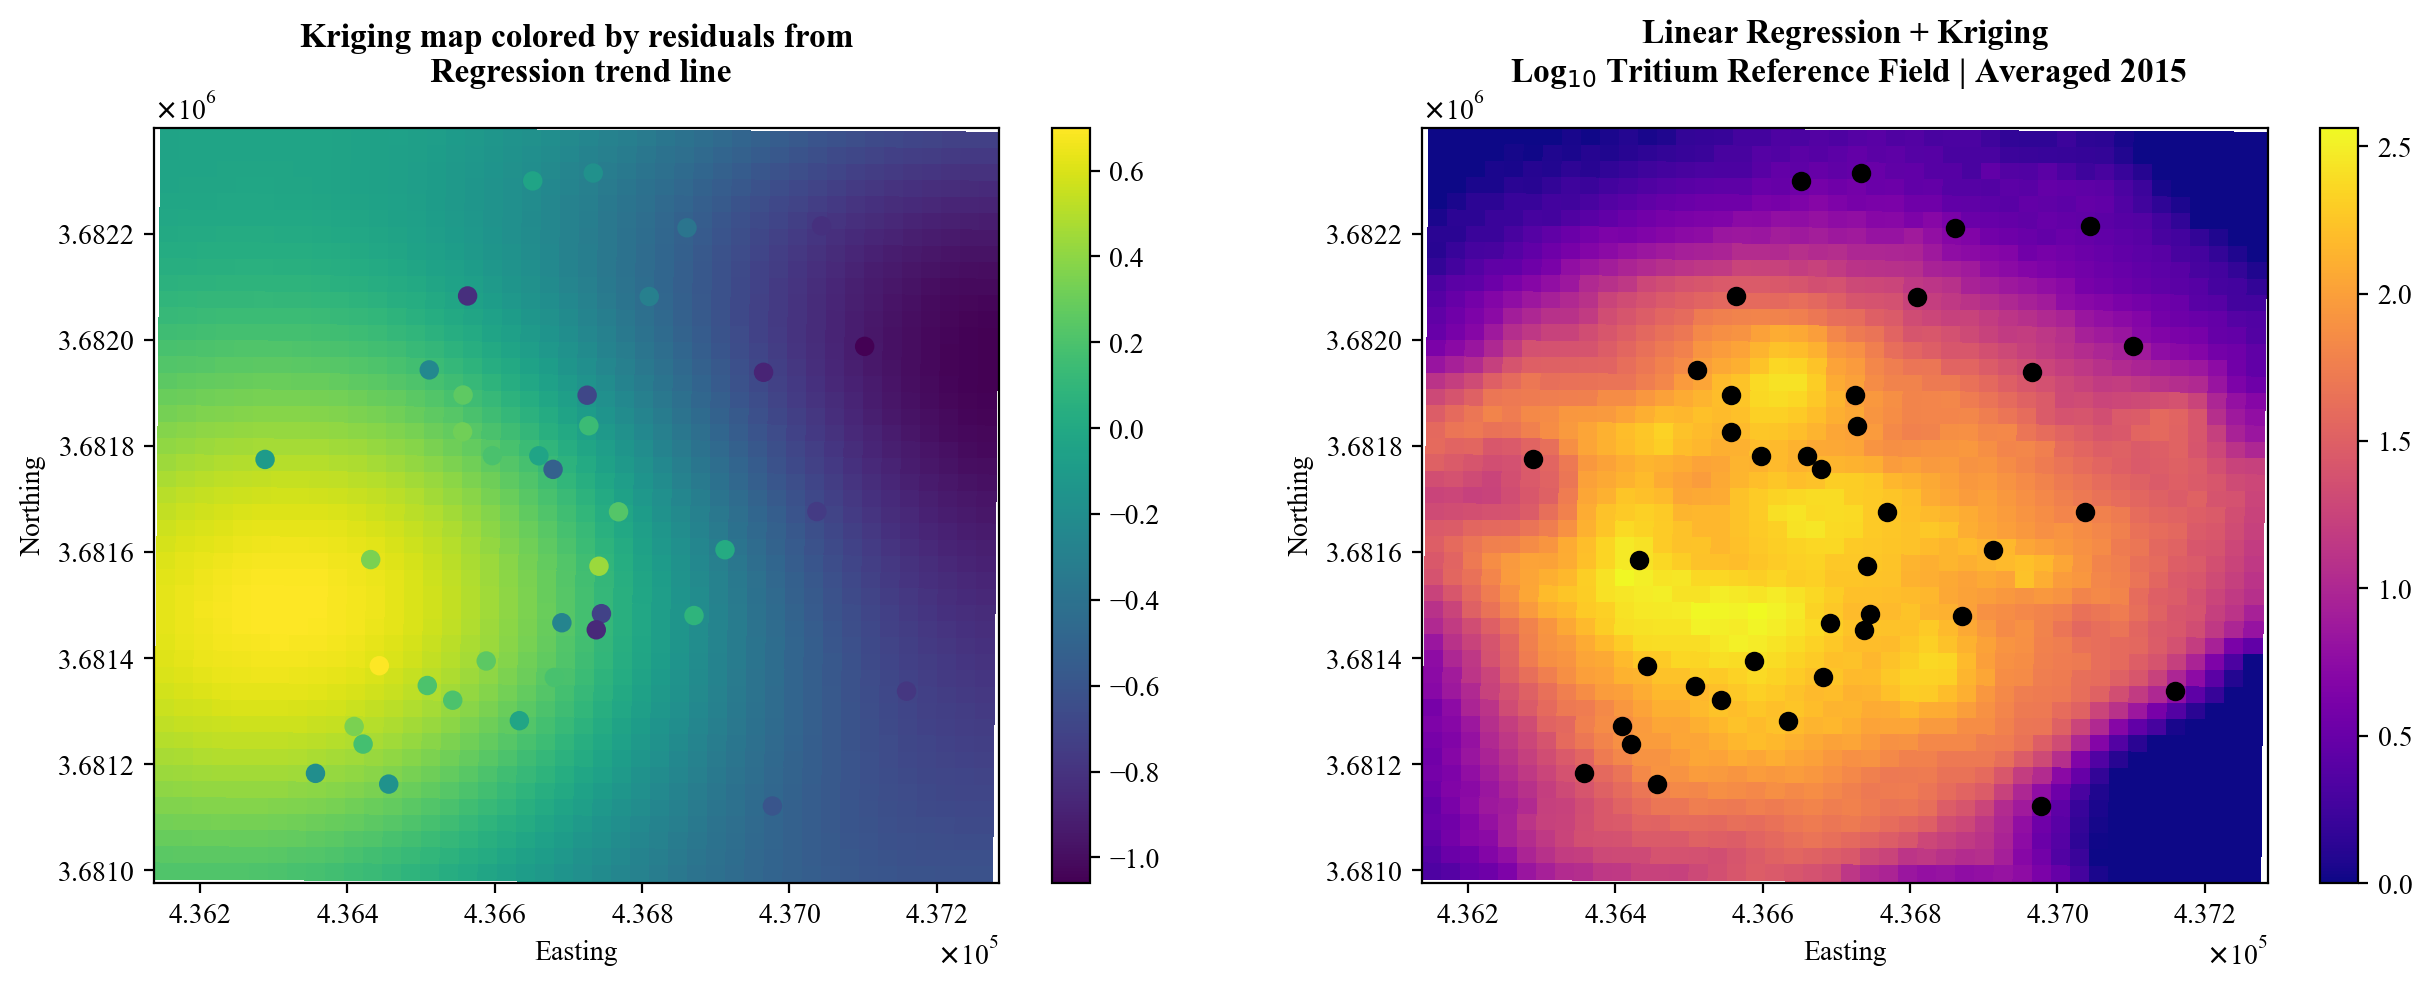

In [38]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
xx = np.array(XX)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}{}".format('$_{10}$',"Averaged ",year,))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1])
colors=[residuals, 'black']
# ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c=colors, alpha=1)
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04,fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

In [40]:
pd.set_option('max_colwidth', 100)

# TEST ALL - Regular Fitting Process
model_results = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results 
gp, y_map_gp = pylenm_df.fit_gp(X=X[['Easting', 'Northing']], y=y, xx=XX[['Easting', 'Northing']])
# y_map_gp = y_map_gp_here
X_approx, y_approx = get_approx_predictions(X, y_map_gp, XX)
model_results.loc[len(model_results.index)] = ["GP", np.NaN, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

feature_params = [['Elevation'], ['Elevation', 'dist_to_basin'],['Elevation', 'Slope'], ['Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing'], ['Easting', 'Northing', 'Elevation'], ['Easting', 'Northing', 'Elevation', 'dist_to_basin'],
['Easting', 'Northing', 'Elevation', 'Slope'], ['Easting', 'Northing', 'Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc', 'dist_to_basin']]

# Save Results for our approach  
for ft in feature_params:
    y_map_lr, r_map_lr, residuals_lr, lr_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='linear', smooth=True)
    y_map_rf, r_map_rf, residuals_rf, rf_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='rf', smooth=True)
    y_map_rid, r_map_rid, residual_rid, rid_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='ridge', smooth=True)
    y_map_las, r_map_las, residuals_las, las_trend = pylenm_df.interpolate_topo(X, y, XX, ft=ft, regression='lasso', smooth=True)
    y_map_lr[y_map_lr<0] = 0
    y_map_rf[y_map_rf<0] = 0
    y_map_rid[y_map_rid<0] = 0
    y_map_las[y_map_las<0] = 0

    y_maps = [y_map_lr, y_map_rf, y_map_rid, y_map_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_map, model_name in zip(y_maps, model_names):
        X_approx, y_approx = get_approx_predictions(X, y_map, XX)
        model_results.loc[len(model_results.index)] = [model_name, ft, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

In [41]:
model_results.sort_values(by='r2', ascending=False)

,model,features,mse,r2
32,Lasso,"[Easting, Northing, Elevation, Slope]",0.003014,0.995873
40,Lasso,"[Easting, Northing, Elevation, Slope, Acc]",0.003014,0.995873
31,Ridge,"[Easting, Northing, Elevation, Slope]",0.004766,0.993473
12,Lasso,"[Elevation, Slope]",0.004880,0.993317
29,Linear,"[Easting, Northing, Elevation, Slope]",0.005624,0.992298
39,Ridge,"[Easting, Northing, Elevation, Slope, Acc]",0.005694,0.992201
37,Linear,"[Easting, Northing, Elevation, Slope, Acc]",0.007462,0.989780
44,Lasso,"[Easting, Northing, Elevation, Slope, Acc, dist_to_basin]",0.018918,0.974091
15,Ridge,"[Elevation, Slope, dist_to_basin]",0.061829,0.915324
16,Lasso,"[Elevation, Slope, dist_to_basin]",0.063888,0.912504


In [42]:
# TEST ALL - Leave-One-Out Cross Validation Process
model_results_LOO = pd.DataFrame(columns=['model', 'features', 'mse', 'r2'])

# Save GP results
y_approx_loo_gp = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gp, y_map_gp = pylenm_df.fit_gp(X=X_train[['Easting', 'Northing']], y=y_train, xx=XX[['Easting', 'Northing']])
    X_approx_test_gp, y_approx_test_gp = get_approx_predictions(X_test, y_map_gp, XX)
    y_approx_loo_gp.append(y_approx_test_gp)
model_results_LOO.loc[len(model_results_LOO.index)] = ["GP", np.NaN, pylenm_df.mse(y, y_approx_loo_gp), r2_score(y, y_approx_loo_gp)]

feature_params = [['Elevation'], ['Elevation', 'dist_to_basin'],['Elevation', 'Slope'], ['Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing'], ['Easting', 'Northing', 'Elevation'], ['Easting', 'Northing', 'Elevation', 'dist_to_basin'],
['Easting', 'Northing', 'Elevation', 'Slope'], ['Easting', 'Northing', 'Elevation', 'Slope', 'dist_to_basin'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'], ['Easting', 'Northing', 'Elevation', 'Slope', 'Acc', 'dist_to_basin']]

# Save Results for our approach  
for ft in feature_params:
    y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las = [], [], [], []
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_map_lr, r_map_lr, residuals_lr, lr_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='linear', smooth=True)
        y_map_rf, r_map_rf, residuals_rf, rf_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='rf', smooth=True)
        y_map_rid, r_map_rid, residual_rid, rid_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='ridge', smooth=True)
        y_map_las, r_map_las, residuals_las, las_trend = pylenm_df.interpolate_topo(X_train, y_train, XX, ft=ft, regression='lasso', smooth=True)
        
        y_map_lr[y_map_lr<0] = 0
        y_map_rf[y_map_rf<0] = 0
        y_map_rid[y_map_rid<0] = 0
        y_map_las[y_map_las<0] = 0

        X_approx_test_lr, y_approx_test_lr = get_approx_predictions(X_test, y_map_lr, XX)
        X_approx_test_rf, y_approx_test_rf = get_approx_predictions(X_test, y_map_rf, XX)
        X_approx_test_rid, y_approx_test_rid = get_approx_predictions(X_test, y_map_rid, XX)
        X_approx_test_las, y_approx_test_las = get_approx_predictions(X_test, y_map_las, XX)
        
        y_approx_loo_lr.append(y_approx_test_lr)
        y_approx_loo_rf.append(y_approx_test_rf)
        y_approx_loo_rid.append(y_approx_test_rid)
        y_approx_loo_las.append(y_approx_test_las)

    y_preds = [y_approx_loo_lr, y_approx_loo_rf, y_approx_loo_rid, y_approx_loo_las]
    model_names = ["Linear", "Random Forest", "Ridge", "Lasso"]
    for y_approx, model_name in zip(y_preds, model_names):
        model_results_LOO.loc[len(model_results_LOO.index)] = [model_name, ft, pylenm_df.mse(y, y_approx), r2_score(y, y_approx)]

In [43]:
model_results_LOO.sort_values(by='r2', ascending=False)

,model,features,mse,r2
25,Linear,"[Easting, Northing, Elevation, dist_to_basin]",0.404822,0.445583
27,Ridge,"[Easting, Northing, Elevation, dist_to_basin]",0.405623,0.444487
33,Linear,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.424165,0.419092
15,Ridge,"[Elevation, Slope, dist_to_basin]",0.424329,0.418868
16,Lasso,"[Elevation, Slope, dist_to_basin]",0.426009,0.416567
13,Linear,"[Elevation, Slope, dist_to_basin]",0.426009,0.416567
35,Ridge,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.429822,0.411345
28,Lasso,"[Easting, Northing, Elevation, dist_to_basin]",0.434357,0.405133
34,Random Forest,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.445084,0.390443
36,Lasso,"[Easting, Northing, Elevation, Slope, dist_to_basin]",0.456030,0.375452


In [44]:
y_map, r_map, residuals, trend = pylenm_df.interpolate_topo(X, y, XX, ft=['Easting', 'Northing', 'Elevation','Slope', 'Acc'], regression='lasso', smooth=True)
y_map[y_map<0] = 0

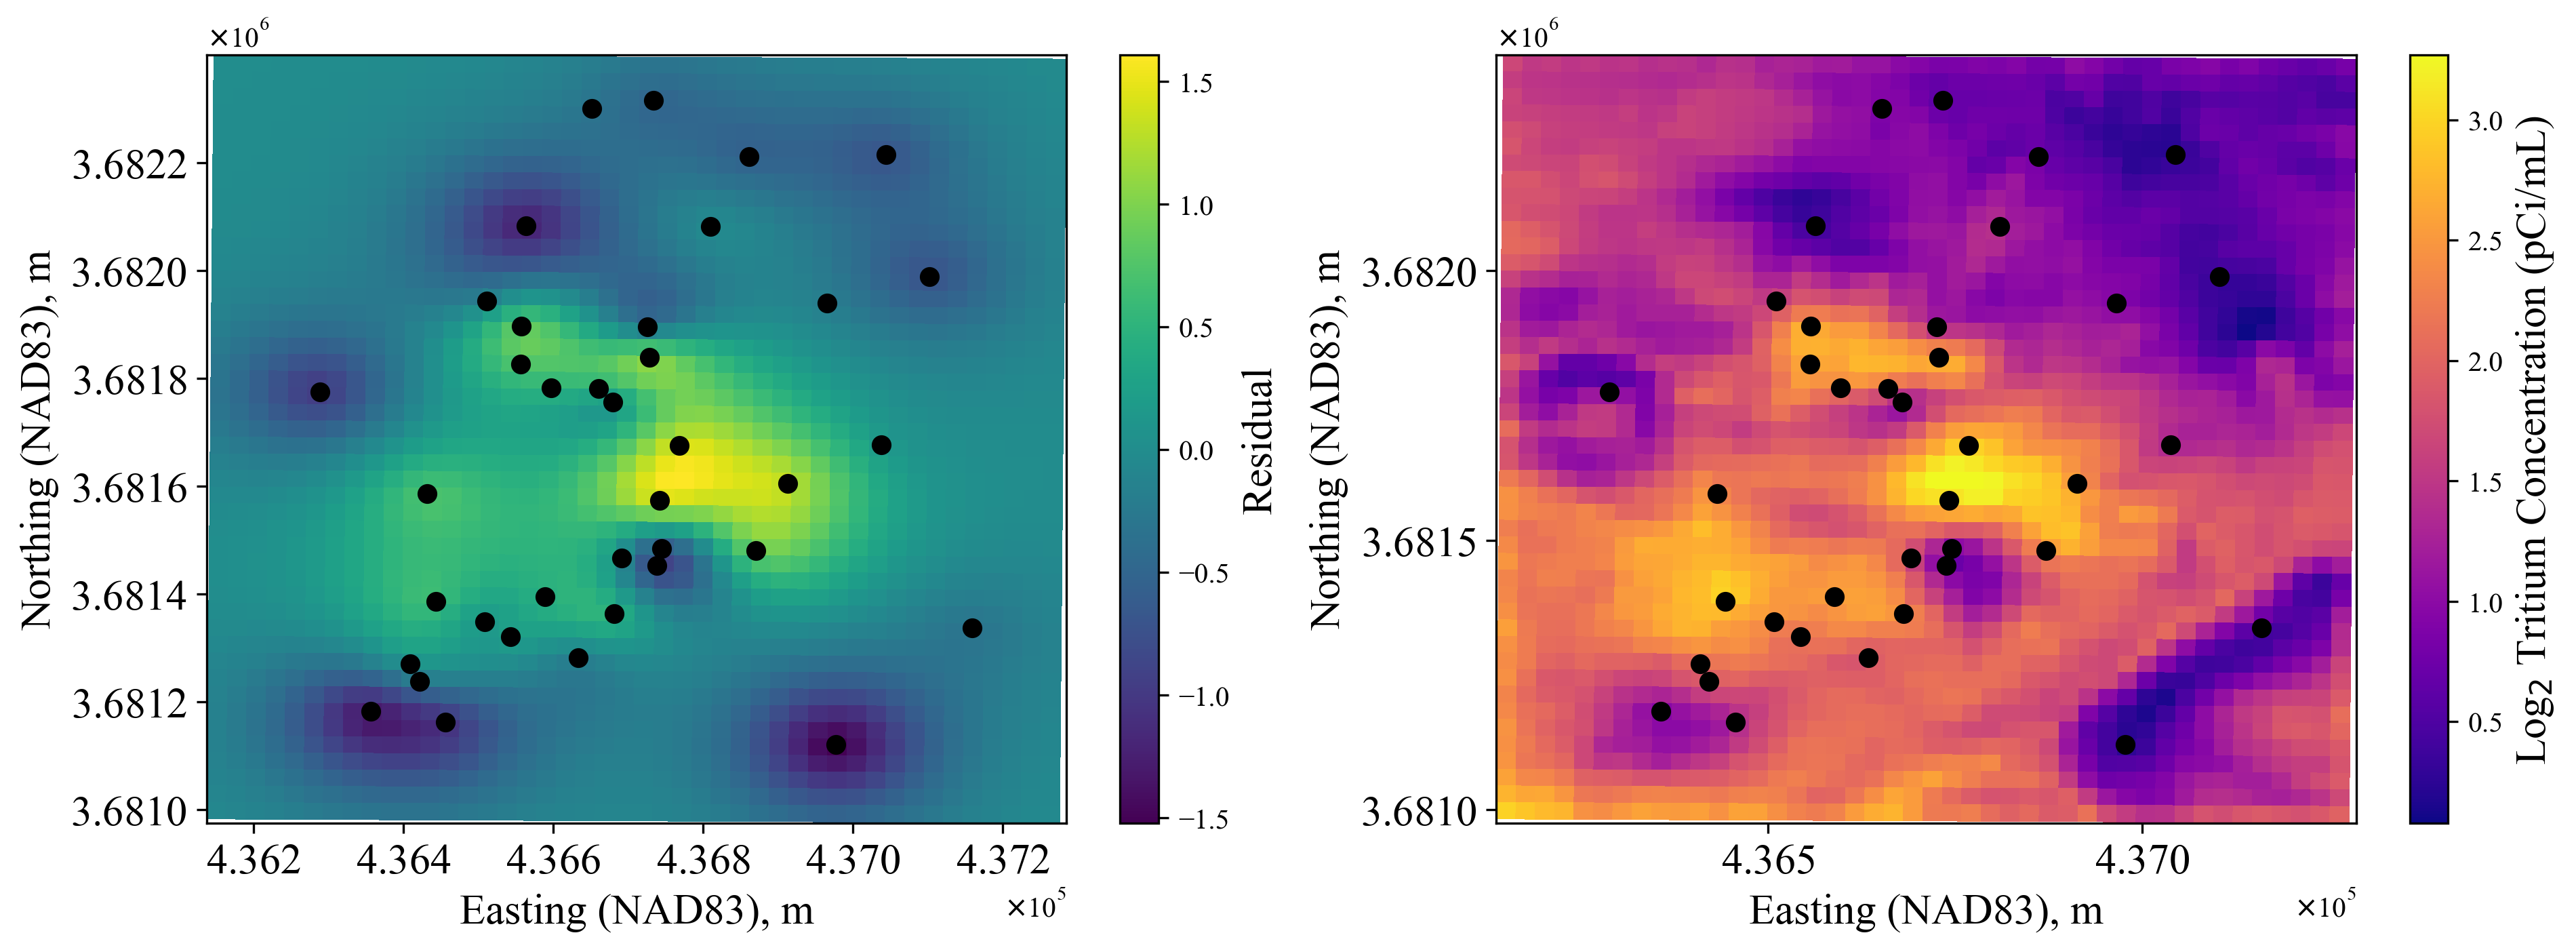

In [45]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
fontsize=15
xx = np.array(XX)
plt.locator_params(axis='both', nbins=4, tight=False)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Log{} Tritium Reference Field | {}".format('$_{2}$',"Averaged 2011",))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0]).set_label(label='Residual',size=fontsize)
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$',pylenm_df.get_unit('TRITIUM')), size=fontsize)
colors=['black', 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1, cmap='plasma')
    plt.rc('font', size=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)
fig.show()

In [46]:
X_approx, y_approx = get_approx_predictions(X, y_map, XX)

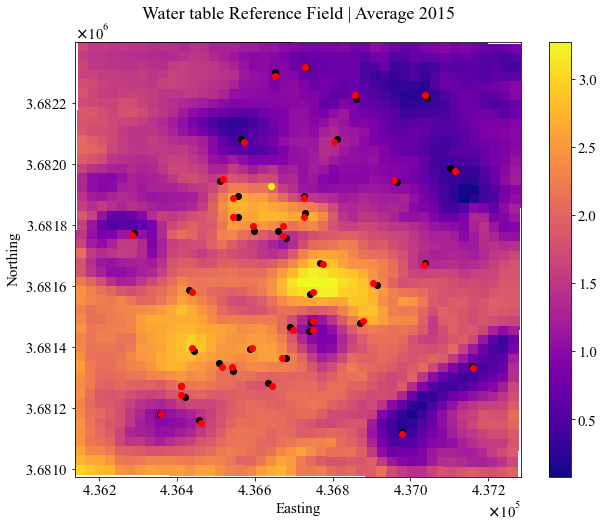

In [47]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))
xx = np.array(XX)
titles = [str("Water table Reference Field | Average {}".format(year))]
map_1 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax)
ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1) # Approximate point
ax.scatter(b_c[0], b_c[1], c='yellow', alpha=1) # Approximate point
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

MSE LR:  0.003013548567073045
R^2 LR:  0.9958728483456377
[0.    0.006 0.012 0.018 0.024 0.03 ]


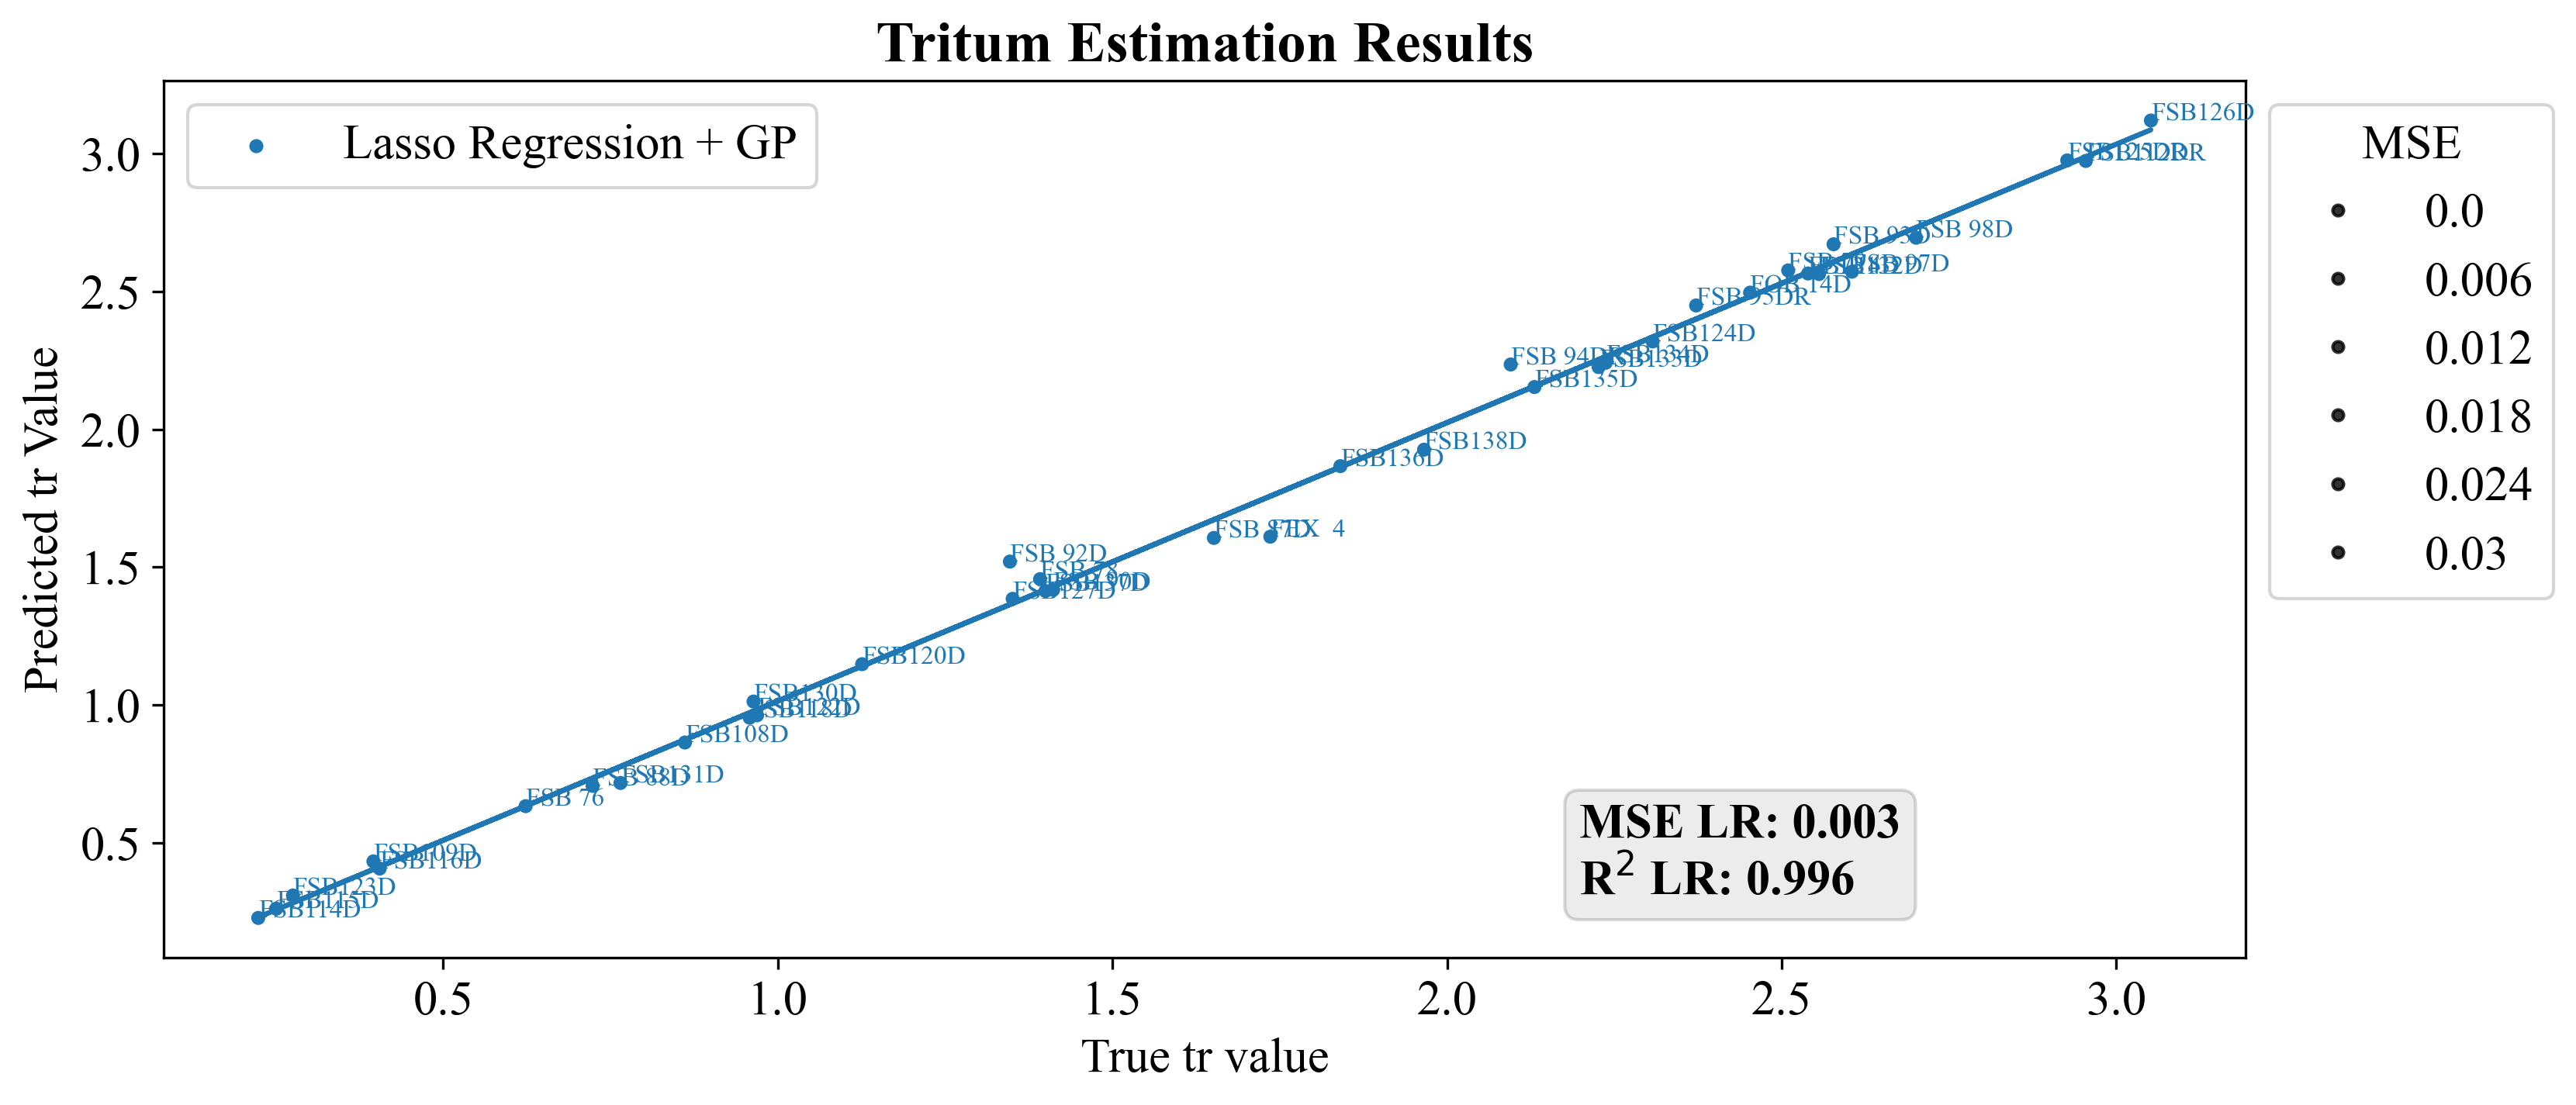

<Figure size 1200x800 with 0 Axes>

In [48]:
fig, ax = plt.subplots(figsize=(10,5),dpi=300)
plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ",pylenm_df.mse(y, y_approx))

print("R^2 LR: ",r2_score(y, y_approx))
text = "MSE LR: {:.3f}".format(pylenm_df.mse(y, y_approx)) + "\n" + "R{} LR: {:.3f}".format('$^{2}$', r2_score(y, y_approx))
plt.figure( dpi=200)
ax.set_title('Tritum Estimation Results',fontweight='bold')
ax.set_xlabel('True tr value')
ax.set_ylabel('Predicted tr Value')

err_lr = []
for i in range(len(y)):
    err_lr.append(pylenm_df.mse([y[i]], [y_approx[i]]))
minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
scatter1 = ax.scatter(y, y_approx, label = "Lasso Regression + GP", s=err_lr_s)
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
fig.tight_layout()
fig.text(0.68, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props) #1.025, 0.06

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter1.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_lr).min()), max(np.array(err_lr).max(),np.array(err_lr).max()) ,6),3)
print(labels)
legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
for i, txt in enumerate(well_names):
    ax.annotate(txt, (y[i], y_approx[i]), fontsize=8, color='#1f77b4')

ax.plot(y, m_lr*y + b_lr)